In [131]:
%%capture

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

matplotlib.rcParams.update({'font.size': 14})
plt.tight_layout()

_TODO: add documentation info from cohort maps._

# Data Exploration

Let's take a look at Columbia's average net prices since 2008 (when colleges began reporting student aid data).

Note that the years in the scorecard data filenames correspond to when the data was collected. For example, the 2016-17 data file describes data collected in 2016-17, so it actually describes the 2015-16 academic year.

In [132]:
scorecards = {}

# Read every scorecard file from 2009 to 2016 into a list.
for year in range(9, 17):
    fname = f'MERGED20{year:02}_{(year + 1):02}_PP.csv'
    df = pd.read_csv(SCDIR + fname, low_memory=False)
    # Isolate scorecard data for Columbia University.
    scorecards[2000 + year - 1] = df.set_index('INSTNM').loc['Columbia University in the City of New York']
    print('Finished reading', fname)

Finished reading MERGED2009_10_PP.csv
Finished reading MERGED2010_11_PP.csv
Finished reading MERGED2011_12_PP.csv
Finished reading MERGED2012_13_PP.csv
Finished reading MERGED2013_14_PP.csv
Finished reading MERGED2014_15_PP.csv
Finished reading MERGED2015_16_PP.csv
Finished reading MERGED2016_17_PP.csv


The College Scorecard only has data up to academic year (AY) 2015-16. IPEDS has [more recent financial aid data (in the "Net Price" section)](https://nces.ed.gov/ipeds/datacenter/institutionprofile.aspx?unitId=acababb2abb1) that we have to hard code into the scorecard list.

In [133]:
scorecards[2016] = {
    'NPT41_PRIV': 10917.0,
    'NPT42_PRIV': 6596.0,
    'NPT43_PRIV': 7648.0,
    'NPT44_PRIV': 17463.0,
    'NPT45_PRIV': 42912.0,
}

To adjust prices for inflation, we will use consumer price index data to make price data equivalent to 2016 dollars. The month of 2016 we adjust to depends on when each category of data was calculated. For example, net price data is reported around December, whereas debt data is reported around October.

In [134]:
cpiData = pd.read_csv('../data/ConsumerPriceIndexData.csv').set_index('Year')

In [135]:
# Returns a function that adjusts nominal dollars to [month] 2016 dollars.
def inflationAdjuster(month):
    finalCpi = cpiData.loc[2016][month]
    def adjust(dollars, year):
        if dollars is None:
            return
        initCpi = cpiData.loc[year][month]
        return dollars * finalCpi / initCpi
    return adjust

In [136]:
colNames = {
    'NPT41_PRIV': 'ANP for 0-30,000 fam income',
    'NPT42_PRIV': 'ANP for 30,001-48,000 fam income',
    'NPT43_PRIV': 'ANP for 48,001-75,000 fam income',
    'NPT44_PRIV': 'ANP for 75,001-110,000 fam income',
    'NPT45_PRIV': 'ANP for 110,000+ fam income',
}

YEARS = [i for i in range(2008, 2017)]

def getAdjustedValues(col):
    # Net prices are calculated around Nov-Dec.
    # IPEDS help desk when asked if I could use December CPI's to adjust
    # net prices for inflation: "Probably." —Mike (the one person who
    # runs the help desk). 🧐
    adjust = inflationAdjuster('Dec')
    return [
        adjust(scorecards[year][col], year) for year in YEARS
    ]

def comparePriceLines(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getAdjustedValues(col), label=colNames.get(col, col))        
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Average net price in December 2016 dollars')
    plt.ylim(bottom=0)
    if title:
        plt.title(title)

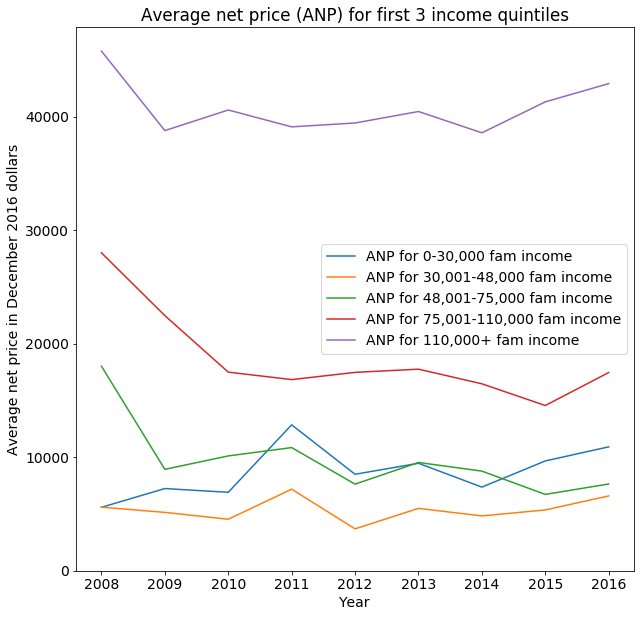

In [141]:
comparePriceLines(
    'NPT41_PRIV',
    'NPT42_PRIV',
    'NPT43_PRIV',
    'NPT44_PRIV',
    'NPT45_PRIV',
    title='Average net price (ANP) for first 3 income quintiles'
)

In [142]:
# Retrieves percent increase column data since 2009 for every year
def getPriceIncreases(col):
    data = getAdjustedValues(col)
    initial = data[0]
    return [
        (d - initial) / initial
        for d in data
    ]

def compareAggregatePriceIncreases(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getPriceIncreases(col), label=colNames.get(col, col))
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Percent increase since 2009 (not adjusted for inflation)')
    plt.axhline(y=0, linestyle='--', color='#aaaaaa')
    plt.ylim(top=2,bottom=-1)
    if title:
        plt.title(title)    

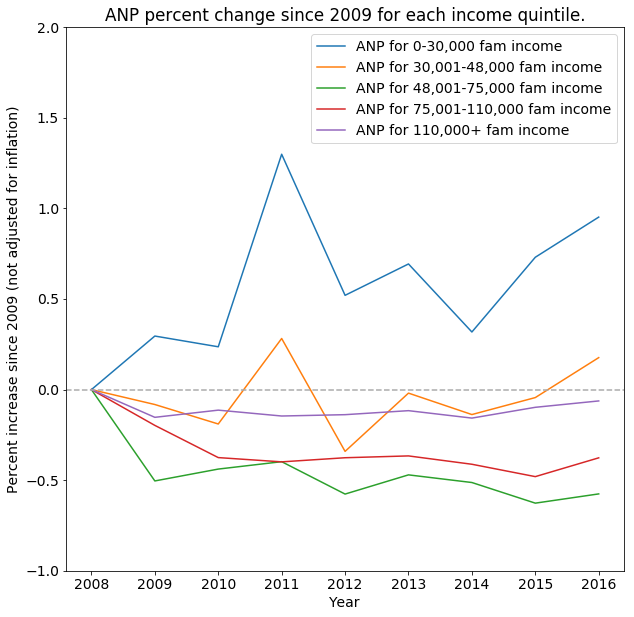

In [143]:
compareAggregatePriceIncreases(
    'NPT41_PRIV',
    'NPT42_PRIV',
    'NPT43_PRIV',
    'NPT44_PRIV',
    'NPT45_PRIV',n
    title="ANP percent change since 2009 for each income quintile."
)

# Debt

According to the [College Scorecard Data Documentation (page 18)](https://collegescorecard.ed.gov/assets/FullDataDocumentation.pdf), debt data for each cohort (e.g. low income, medium income, pell grant students) is produced for each fiscal year. Fiscal years end on September 30, so the CPI's I use for each year are from September.

In [120]:
colNames = {
    'LO_INC_DEBT_MDN': 'median debt for 0-30k students',
    'MD_INC_DEBT_MDN': 'median debt for 30k-75k students',
    'HI_INC_DEBT_MDN': 'median debt for 75k+ students',
}

def getDebtData(col):
    adjust = inflationAdjuster('Sep')
    # No debt data is available for AY 2016-17.
    return [
        adjust(float(scorecards[year][col]), year) for year in YEARS[:-1]
    ] + [None]

def compareDebtLines(*cols, title=None):
    plt.figure(figsize=(10,10))
    for col in cols:
        plt.plot(YEARS, getDebtData(col), label=colNames.get(col, col))        
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Median debt (in nominal dollars)')
    plt.ylim(bottom=0)
    if title:
        plt.title(title)

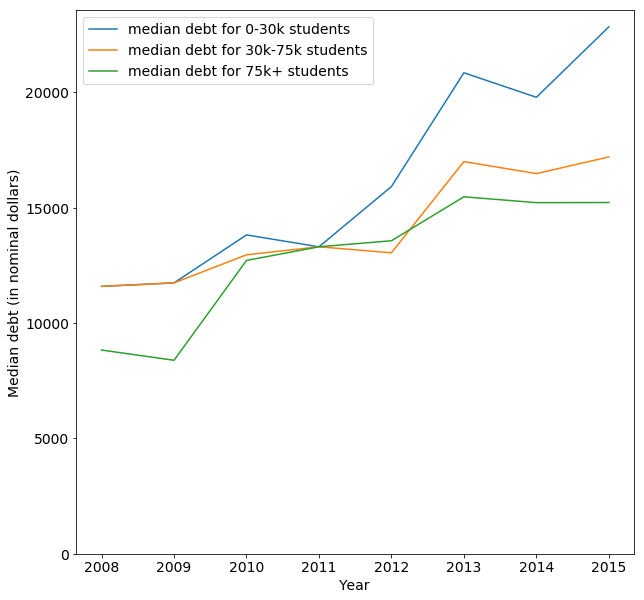

In [121]:
compareDebtLines('LO_INC_DEBT_MDN', 'MD_INC_DEBT_MDN', 'HI_INC_DEBT_MDN')

# Repyament Rates

Let's take a look at repayment rates.

In [122]:
colNames = {
    'CDR2_DENOM': 'number of students in two-year cohort for default',
    'CDR3_DENOM': 'number of students in three-year cohort for default',
}

def getRepaymentData(col):
    # Repayment data is not yet available for AY 2016-17.
    return [float(scorecards[year][col]) for year in YEARS[:-1]] + [None]

def compareRepaymentLines(*cols, title=None, index=0):
    plt.subplot(2, 2, index)
    for col in cols:
        plt.plot(YEARS, getRepaymentData(col), label=colNames.get(col, col))        
    plt.legend()
    plt.ylim(top=1,bottom=0)
    if title:
        plt.title(title)

In [126]:
def compareRepayment():
    plt.figure(figsize=(16,16))
    plt.xlabel('Year')
    plt.ylabel('Repayment rate')
    for n in range(4):
        i = 2*n + 1
        compareRepaymentLines(f'LO_INC_RPY_{i}YR_RT', f'MD_INC_RPY_{i}YR_RT', f'HI_INC_RPY_{i}YR_RT', index=n+1)

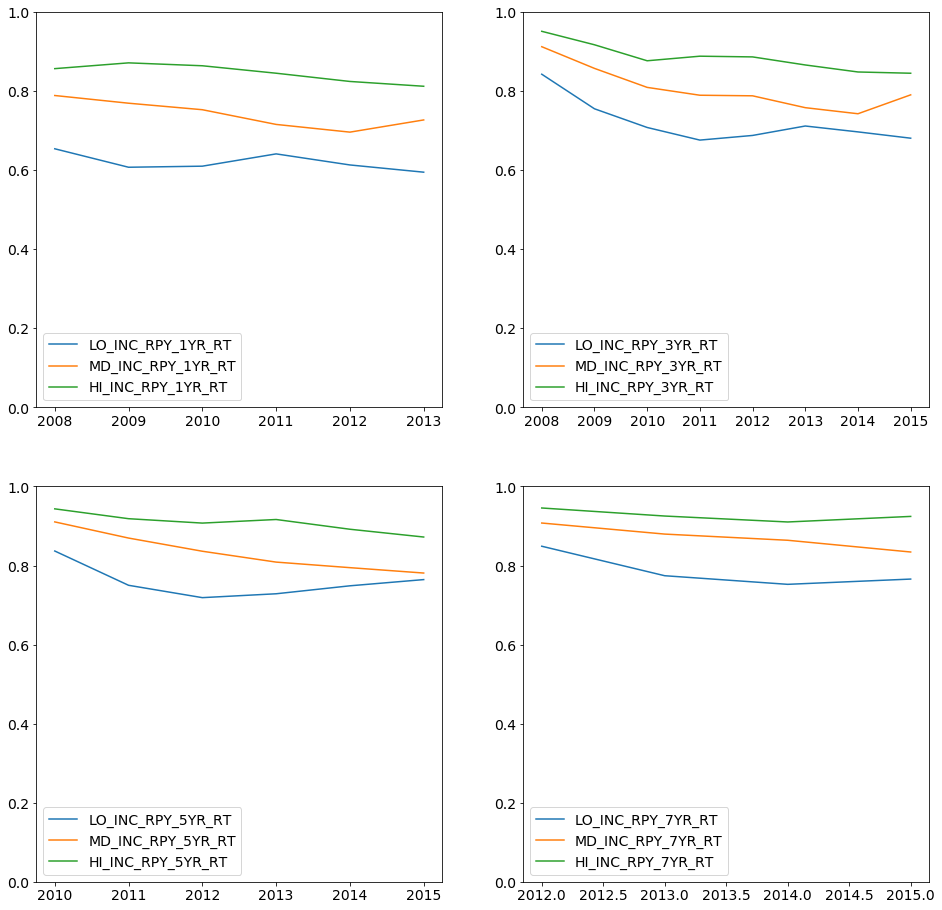

In [127]:
# Note: missing 
compareRepayment()